<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/Abhi_CTCF_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip install pyfasta
!pip install deeptools
!pip install momma_dragonn

!apt-get install bedtools

#Download optimal IDR thresholded peaks
![[ -f idr_optimal_file.narrowPeak.gz ]] || wget https://www.encodeproject.org/files/ENCFF002CEL/@@download/ENCFF002CEL.bed.gz -O idr_optimal_file.narrowPeak.gz
  
#Get hg19 fasta by download 2bit and then converting to fa
![[ -f hg19.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit -O hg19.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg19.genome.fa ]] || ./twoBitToFa hg19.2bit hg19.genome.fa
  
#download hg19 chromsizes file
![[ -f hg19.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes -O hg19.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 10.0MB/s 
    100% |████████████████████████████████| 9.7MB 1.1MB/s 
    100% |████████████████████████████████| 71kB 22.6MB/s 
    100% |████████████████████████████████| 37.8MB 842kB/s 
    100% |████████████████████████████████| 3.1MB 12.1MB/s 
    100% |████████████████████████████████| 8.1MB 5.2MB/s 
    100% |████████████████████████████████| 552kB 21.1MB/s 
    100% |████████████████████████████████| 71kB 26.3MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760c

In [0]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat idr_optimal_file.narrowPeak.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])}' | bedtools slop -g hg19.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t$F[3]"}' | sortBed | gzip -c > positives_asinh_spp.gz
#15% of the regions go to validation and test set. Ensure no overlap between test, valid and train sets using bedtools intersect -v
!zcat positives_asinh_spp.gz | perl -lne 'if ($.%15==0) {print $_}' | gzip -c > test_positives_asinh_spp.gz
!bedtools intersect -sorted -v -a <(zcat positives_asinh_spp.gz | perl -lne 'if ($.%15==10) {print $_}') -b test_positives_asinh_spp.gz -wa | gzip -c > valid_positives_asinh_spp.gz
!bedtools intersect -sorted -v -a positives_asinh_spp.gz -b <(zcat valid_positives_asinh_spp.gz test_positives_asinh_spp.gz | sortBed) -wa | gzip -c > train_positives_asinh_spp.gz

#!zcat positives_asinh_spp.gz | egrep -w -v 'chr2|chr21' | gzip -c > train_positives_asinh_spp.gz
#!zcat positives_asinh_spp.gz | egrep -w 'chr21' | gzip -c > valid_positives_asinh_spp.gz
#!zcat positives_asinh_spp.gz | egrep -w 'chr2' | gzip -c > test_positives_asinh_spp.gz


In [0]:
import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six
from scipy.stats import spearmanr
import numpy as np


def get_single_stream_data_generator(bed_source, batch_size):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               batch_size=batch_size,
               bed_source=bed_source,
               fasta_data_source="hg19.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True)

def train_regression_model(num_outputs,
                           train_bed_source,
                           valid_bed_source,
                           steps_per_epoch=200,
                           batch_size=128,
                           adam_lr=0.001,
                           num_validation_samples=3500,
                           num_conv_filters=15,
                           conv_filter_length=15,
                           pool_length_and_stride=5,
                           num_dense_units=[100],
                           preinit_model=None,
                           epochs_to_train_for=60):
  
  validation_steps = int(num_validation_samples/batch_size)
  
  
  class SpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps, valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[:,0],
                      b=valid_data_preds[:,0]))
      
  
  if (preinit_model is None):
    input = keras.layers.Input(shape=(1000,4), name="sequence")
    conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
    conv1relu = keras.layers.core.Activation(activation="relu")(conv1)
    conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
    conv2relu = keras.layers.core.Activation(activation="relu")(conv2)
    conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
    conv3relu = keras.layers.core.Activation(activation="relu")(conv3)
    avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
    flatten = keras.layers.core.Flatten()(avgpool)
    dense1 = keras.layers.core.Dense(units=num_dense_units[0])(flatten)
    dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
    output = keras.layers.core.Dense(units=num_outputs,
                                              name="output")(dense1relu)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "mse"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_single_stream_data_generator(
      bed_source=train_bed_source,
      batch_size=batch_size).get_batch_generator(),
    validation_data= get_single_stream_data_generator(
      bed_source=valid_bed_source,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               SpearmanCorrCallback(
                   valid_data_generator=get_single_stream_data_generator(
                      bed_source=valid_bed_source,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

In [7]:
from matplotlib import pyplot as plt

positives_asinh_spp_model, positives_asinh_spp_fit_history = train_regression_model(num_outputs=1,
                             train_bed_source="train_positives_asinh_spp.gz",
                             valid_bed_source="valid_positives_asinh_spp.gz")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 15)          915       
_________________________________________________________________
activation_5 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_6 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_7 (Activation)    (None, 1000, 15)          0         
__________

In [8]:
#compute auROC and auPRC
from sklearn.metrics import roc_auc_score, average_precision_score
from avutils import util
import numpy as np

test_set_generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source="test_positives_asinh_spp.gz",
     fasta_data_source="hg19.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)

positives_asinh_spp_preds = []
true_test_labels = []

X_batch = []
for (X_ex, Y_ex, coor, fastastr) in test_set_generator:
  true_test_labels.append(Y_ex)
  if (len(true_test_labels)%1000 == 0):
    print("Done",len(true_test_labels))
  X_batch.append(X_ex)
  if (len(X_batch)==200):
    X_batch = {"sequence": np.array(X_batch)}
    positives_asinh_spp_preds.extend(positives_asinh_spp_model.predict(X_batch))
    X_batch = []
#leftover examples at the end that didn't fit in a batch
if (len(X_batch) > 0):
  X_batch = {"sequence": np.array(X_batch)}
  positives_asinh_spp_preds.extend(positives_asinh_spp_model.predict(X_batch))

positives_asinh_spp_preds = np.array(positives_asinh_spp_preds)
true_test_labels = np.array(true_test_labels)

Reading bed file test_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 3466rows
Done 1000
Done 2000
Done 3000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: generator 'get_pyfasta_generator' raised StopIteration


In [9]:
from scipy.stats import spearmanr
print(spearmanr(a=true_test_labels[:,0],
                b=positives_asinh_spp_preds[:,0]))

SpearmanrResult(correlation=0.6333029683424352, pvalue=0.0)


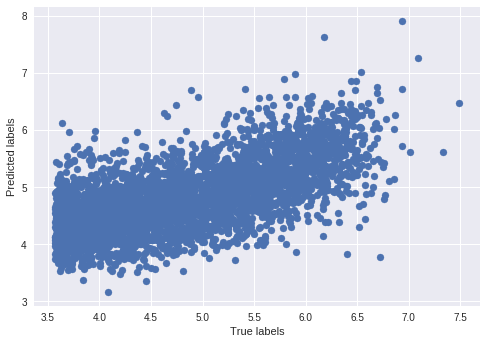

In [10]:
from matplotlib import pyplot as plt
plt.scatter(true_test_labels[:,0], positives_asinh_spp_preds[:,0])
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()